In [1]:
%matplotlib inline


# Music Synchronization with Dynamic Time Warping


In this short tutorial, we demonstrate the use of dynamic time warping (DTW) for music synchronization
which is implemented in `librosa`.

We assume that you are familiar with the algorithm and focus on the application. Further information about
the algorithm can be found in the literature, e. g. [1].

Our example consists of two recordings of the first bars of the famous
brass section lick in Stevie Wonder's rendition of "Sir Duke".
Due to differences in tempo, the first recording lasts for ca. 7 seconds and the second recording for ca. 5 seconds.
Our objective is now to find an alignment between these two recordings by using DTW.




In [2]:
# Code source: Stefan Balke
# License: ISC
# sphinx_gallery_thumbnail_number = 4

from __future__ import print_function
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import librosa
import librosa.display
import sys
try:
    sys.getwindowsversion()
except AttributeError:
    isWindows = False
else:
    isWindows = True

if isWindows:
    import win32api,win32process,win32con
    pid = win32api.GetCurrentProcessId()
    handle = win32api.OpenProcess(win32con.PROCESS_ALL_ACCESS, True, pid)
    win32process.SetPriorityClass(handle, win32process.HIGH_PRIORITY_CLASS)

---------------------
Load Audio Recordings
---------------------
First, let's load a first version of our audio recordings.



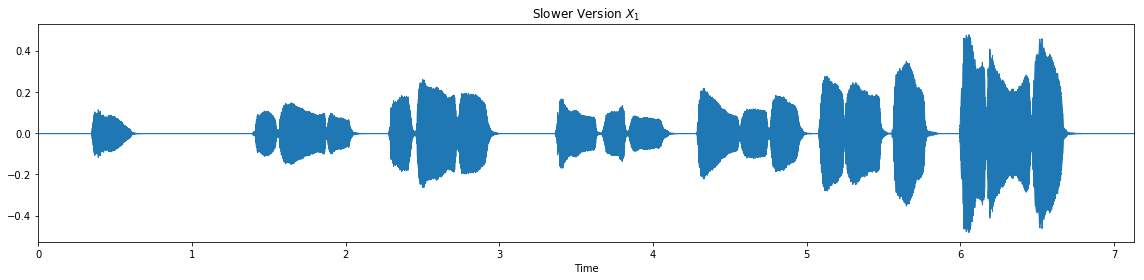

In [3]:
x_1, fs = librosa.load('audio/sir_duke_slow.mp3')
plt.figure(figsize=(16, 4))
librosa.display.waveplot(x_1, sr=fs)
plt.title('Slower Version $X_1$')
plt.tight_layout()

And a second version, slightly faster.



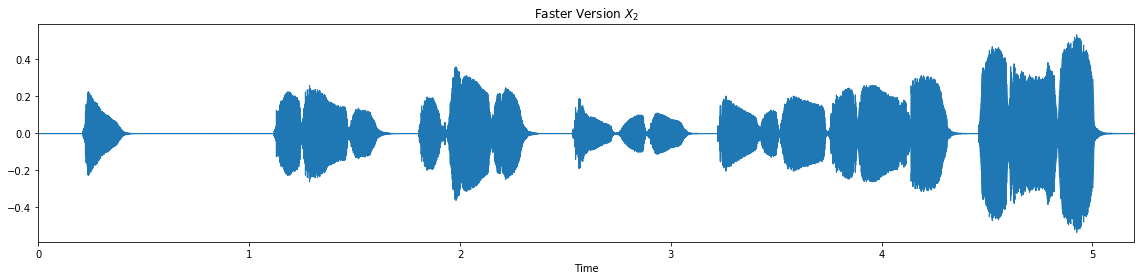

In [4]:
x_2, fs = librosa.load('audio/sir_duke_fast.mp3')
plt.figure(figsize=(16, 4))
librosa.display.waveplot(x_2, sr=fs)
plt.title('Faster Version $X_2$')
plt.tight_layout()

-----------------------
Extract Chroma Features
-----------------------



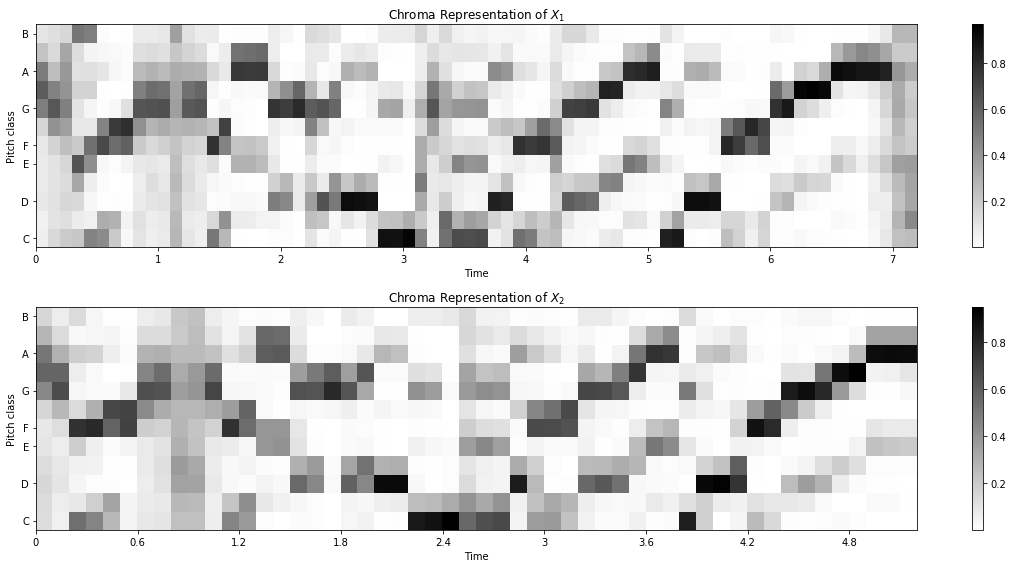

In [5]:
n_fft = 4410
hop_size = 2205

x_1_chroma = librosa.feature.chroma_stft(y=x_1, sr=fs, tuning=0, norm=2,
                                         hop_length=hop_size, n_fft=n_fft)
x_2_chroma = librosa.feature.chroma_stft(y=x_2, sr=fs, tuning=0, norm=2,
                                         hop_length=hop_size, n_fft=n_fft)

plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plt.title('Chroma Representation of $X_1$')
librosa.display.specshow(x_1_chroma, x_axis='time',
                         y_axis='chroma', cmap='gray_r', hop_length=hop_size)
plt.colorbar()
plt.subplot(2, 1, 2)
plt.title('Chroma Representation of $X_2$')
librosa.display.specshow(x_2_chroma, x_axis='time',
                         y_axis='chroma', cmap='gray_r', hop_length=hop_size)
plt.colorbar()
plt.tight_layout()

----------------------
Align Chroma Sequences
----------------------



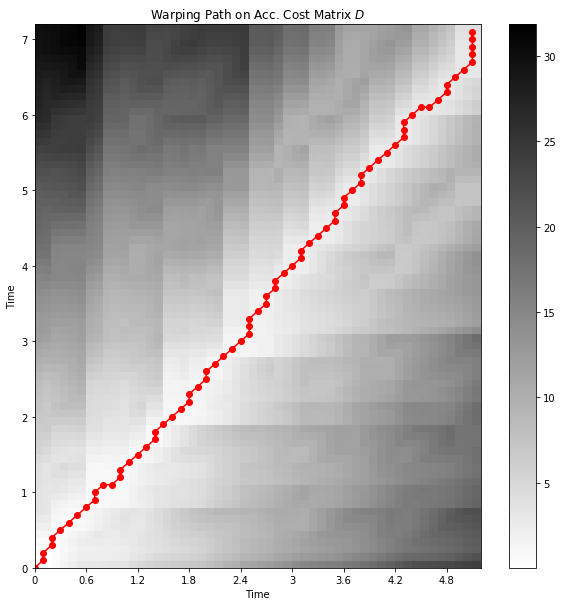

In [6]:
D, wp = librosa.core.dtw(X=x_1_chroma, Y=x_2_chroma, metric='cosine')
wp_s = np.asarray(wp) * hop_size / fs

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
librosa.display.specshow(D, x_axis='time', y_axis='time',
                         cmap='gray_r', hop_length=hop_size)
imax = ax.imshow(D, cmap=plt.get_cmap('gray_r'),
                 origin='lower', interpolation='nearest', aspect='auto')
ax.plot(wp_s[:, 1], wp_s[:, 0], marker='o', color='r')
plt.title('Warping Path on Acc. Cost Matrix $D$')
plt.colorbar()

--------------------------------------------
Alternative Visualization in the Time Domain
--------------------------------------------

We can also visualize the wariping path directly on our time domain signals.
Red lines connect corresponding time positions in the input signals.
(Thanks to F. Zalkow for the nice visualization.)



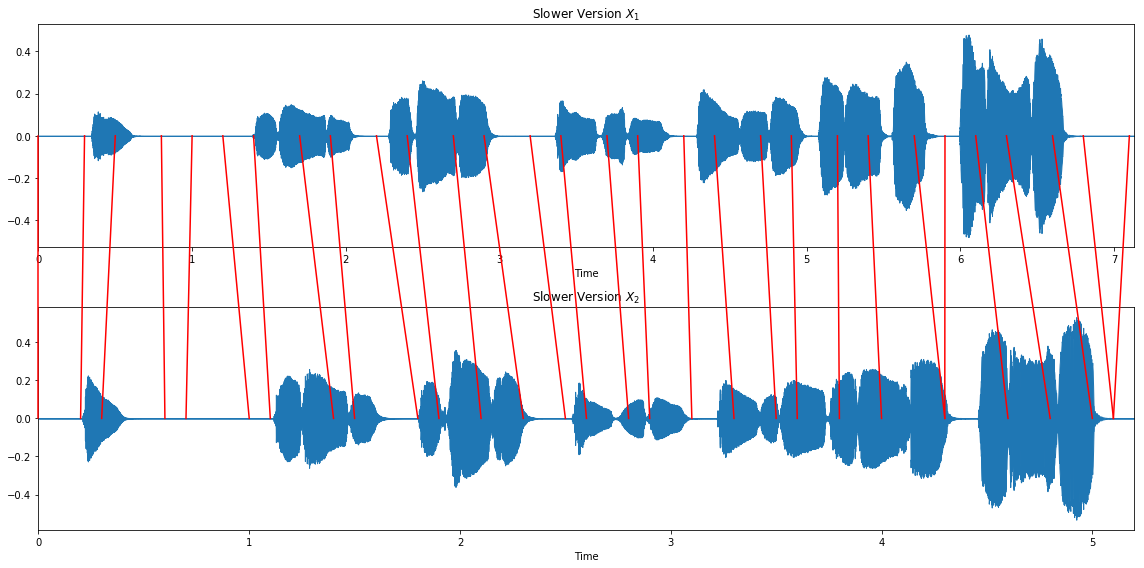

In [7]:
fig = plt.figure(figsize=(16, 8))

# Plot x_1
plt.subplot(2, 1, 1)
librosa.display.waveplot(x_1, sr=fs)
plt.title('Slower Version $X_1$')
ax1 = plt.gca()

# Plot x_2
plt.subplot(2, 1, 2)
librosa.display.waveplot(x_2, sr=fs)
plt.title('Slower Version $X_2$')
ax2 = plt.gca()

plt.tight_layout()

trans_figure = fig.transFigure.inverted()
lines = []
arrows = 30
points_idx = np.int16(np.round(np.linspace(0, wp.shape[0] - 1, arrows)))

# for tp1, tp2 in zip((wp[points_idx, 0]) * hop_size, (wp[points_idx, 1]) * hop_size):
for tp1, tp2 in wp[points_idx] * hop_size / fs:
    # get position on axis for a given index-pair
    coord1 = trans_figure.transform(ax1.transData.transform([tp1, 0]))
    coord2 = trans_figure.transform(ax2.transData.transform([tp2, 0]))

    # draw a line
    line = matplotlib.lines.Line2D((coord1[0], coord2[0]),
                                   (coord1[1], coord2[1]),
                                   transform=fig.transFigure,
                                   color='r')
    lines.append(line)

fig.lines = lines
plt.tight_layout()

-------------
Next steps...
-------------

Alright, you might ask where to go from here.
Once we have the warping path between our two signals,
we could realize different applications.
One example is a player which enables you to navigate between
different recordings of the same piece of music,
e.g. one of Wagner's symphonies played by an orchestra or in a piano-reduced version.

Another example is that you could apply time scale modification algorithms,
e.g. speed up the slower signal to the tempo of the faster one.

----------
Literature
----------

[1] Meinard Müller, Fundamentals of Music Processing — Audio, Analysis, Algorithms, Applications.
Springer Verlag, 2015.

